# Calibration of a Ineterest Rate Swap Curve for Colombia Interbank Rate (IBR) 

In this notebook I calibrate a interest rate swaps curve for prixing IRS for the colombian IBR market. The code follows the calibration method propose by Hagan and West in this [paper](https://www.deriscope.com/docs/Hagan_West_curves_AMF.pdf ). 

For this example i'm using market data from march 21 of 2019 for the most liquid swaps in the market. IRS swaps in colombia are based on the 3 month interbank rate a.k.a IBR and are traded bullet for terms less than 2 years. For longer term swaps they have payments each 3 months and dates are count with a 360 base. 

In [1]:
import numpy as np
import seaborn as sns
import pandas as pd
import datetime
import IRS

import matplotlib.pyplot as plt
import matplotlib.lines as mlines

In [2]:
swaps_rates = [4.225,4.1200,4.1650,4.2100,4.2700,4.4500,4.4750,4.7300,4.9400,
             5.1350,5.3100,5.4650,5.6050,5.7350,5.8450]
swaps_term = [1/360] + (np.array([3,6,9,12,18])/12).tolist() + [2.0,3.0,4.0,5.0,6.0,7.0,8.0,9.0,10.0]
date_val = datetime.date(2019,3,21)
curve_term = swaps_term

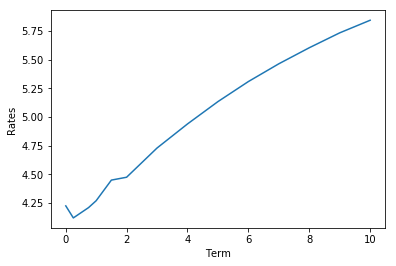

In [3]:
df_swaps = pd.DataFrame({'Term': swaps_term,'Rates': swaps_rates})
sns.lineplot(x="Term", y="Rates", data=df_swaps, markers=True)

The variable swap_rates contains the coupon thats paying the fix rate leg of the swap. For example a IBR swap for 2 years is paying a fix rate of 4.475 for swaping IBR 3 months. 
To be able to price any swap we need a yield curve to calculate discount factors for the fix rate leg. At T = 0 the variable leg always has a value of par. 

## 1. Curve Calibration

First we initialize the calibration object. It has the date of calibration (date_val) and the rates observed in the market. For simplicity we specified the terms of calibration the same as the one of the rates from the market, but it could be different termns. 
Note that the termn and the rates enter as a list.

In [4]:
curveObj = IRS.IRSCurveCalibration(date_val = date_val, swaps_rates = df_swaps.Rates.tolist(),
                            swaps_term = df_swaps.Term.tolist(), curve_term = df_swaps.Term.tolist())

The calibration is done via bootstrapping the rates. For bullet swaps it is posible to calculate exact rates but for OIS they have to be looped.

In [5]:
ibr_curve = curveObj.CurveCalibration()

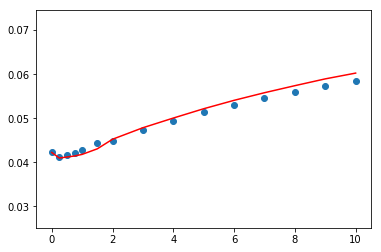

In [6]:
fig, ax = plt.subplots()
ax.scatter(df_swaps["Term"].tolist(),(df_swaps["Rates"]/100).tolist())
line = mlines.Line2D(ibr_curve[:, 0], ibr_curve[:, 1], color='red')
ax.add_line(line)

## 2. Swap Pircing

With the curve we can calibrate a swap at at T = 0, for other dates we would have to include the realice IBR rate to calcualte acumulated coupon of the variable rate leg. 
For this example I price a swal with a coupon of 5.5 and a term of 6.5 years. 

The resulting price is based on a par value of 1

In [12]:
swap = IRS.IRSwap(ibr_curve, market_rate = 5.5, term = 6.5, date_val = date_val, date_end = date_val+ pd.DateOffset(months = 6.5*12))
swap_price = swap.IRSPricing()
print(f'The price of the swap is: {round(swap_price,4)}')

The price of the swap is: 0.9533
